# MVP and HRP Portfolio Design for Private Banks Sector Stocks


<a id='1'></a>
## 1. Loading the Data and Python Libraries

<a id='1.1'></a>
### 1.1. Loading the Python Libraries

In [33]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import date

#Import Model Packages 
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold

#Package for optimization of mean variance optimization
import cvxopt as opt
from cvxopt import blas, solvers


<a id='1.2'></a>
### 1.2. Loading the Data

In [34]:
# load dataset
dataset = read_csv('pvt_banks.csv',index_col=0)

In [35]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [36]:
type(dataset)

pandas.core.frame.DataFrame

<a id='2'></a>
## 2. Exploratory Data Analysis

In [37]:
# shape
dataset.shape

(1481, 10)

In [38]:
# peek at data
set_option('display.width', 100)
dataset.head()

HDFCBANK   ICICIBANK   KOTAKBANK    AXISBANK  INDUSINDBK  BANDHANBNK  FEDERALBNK  \
date                                                                                             
01-01-2016  544.375000  239.090912  727.250000  449.899994  963.849976         NaN   56.950001   
04-01-2016  535.250000  232.318176  705.299988  438.399994  934.200012         NaN   55.799999   
05-01-2016  531.200012  233.363632  707.750000  436.450012  935.250000         NaN   55.750000   
06-01-2016  533.549988  227.363632  703.599976  430.700012  943.950012         NaN   54.849998   
07-01-2016  528.099976  224.318176  691.650024  409.250000  925.500000         NaN   52.500000   

            IDFCFIRSTB        CUB  RBLBANK  
date                                        
01-01-2016   60.700001  76.363632      NaN  
04-01-2016   58.950001  76.033058      NaN  
05-01-2016   59.000000  75.123962      NaN  
06-01-2016   57.750000  75.082642      NaN  
07-01-2016   55.900002  74.338844      NaN

<a id='3'></a>
## 3. Data Pre-processing

<a id='3.1'></a>
### 3.1. Data Cleaning
We check for the NAs in the rows, either drop them or fill them with the mean of the column.

In [39]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())
dataset.shape

Null Values = True


(1481, 10)

Getting rid of the columns with more than 30% missing values. 

In [40]:
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

drop_list = sorted(list(missing_fractions[missing_fractions > 0.4].index))

dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

(1481, 10)

Given that there are null values drop the rown contianing the null values.

In [41]:
# Fill the missing values with the last value available in the dataset. 
dataset=dataset.fillna(method='ffill')
dataset.head()

HDFCBANK   ICICIBANK   KOTAKBANK    AXISBANK  INDUSINDBK  BANDHANBNK  FEDERALBNK  \
date                                                                                             
01-01-2016  544.375000  239.090912  727.250000  449.899994  963.849976         NaN   56.950001   
04-01-2016  535.250000  232.318176  705.299988  438.399994  934.200012         NaN   55.799999   
05-01-2016  531.200012  233.363632  707.750000  436.450012  935.250000         NaN   55.750000   
06-01-2016  533.549988  227.363632  703.599976  430.700012  943.950012         NaN   54.849998   
07-01-2016  528.099976  224.318176  691.650024  409.250000  925.500000         NaN   52.500000   

            IDFCFIRSTB        CUB  RBLBANK  
date                                        
01-01-2016   60.700001  76.363632      NaN  
04-01-2016   58.950001  76.033058      NaN  
05-01-2016   59.000000  75.123962      NaN  
06-01-2016   57.750000  75.082642      NaN  
07-01-2016   55.900002  74.338844      NaN

<a id='3.2'></a>
### 3.2. Training and Test Dataset Preparation

For the purpose of clustering, we will be using annual return figures. Let us prepare the dataset for training and testing, by separating 83.30% of the records for training the models and remaining records for testing. These figures have been chosen in such a way that the records of the year 2021 go into the test dataset while other records remain in the training dataset.

In [42]:
X= dataset.copy('deep')
row= len(X)
train_len = int(row*.8330)

In [43]:
X_train = X.head(train_len)

In [44]:
X_train

HDFCBANK   ICICIBANK    KOTAKBANK    AXISBANK  INDUSINDBK  BANDHANBNK  FEDERALBNK  \
date                                                                                               
01-01-2016   544.375000  239.090912   727.250000  449.899994  963.849976         NaN   56.950001   
04-01-2016   535.250000  232.318176   705.299988  438.399994  934.200012         NaN   55.799999   
05-01-2016   531.200012  233.363632   707.750000  436.450012  935.250000         NaN   55.750000   
06-01-2016   533.549988  227.363632   703.599976  430.700012  943.950012         NaN   54.849998   
07-01-2016   528.099976  224.318176   691.650024  409.250000  925.500000         NaN   52.500000   
...                 ...         ...          ...         ...         ...         ...         ...   
23-12-2020  1375.650024  503.600006  1920.750000  592.450012  855.349976  399.049988   64.250000   
24-12-2020  1397.099976  513.549988  1960.599976  610.200012  852.799988  398.149994   65.199997   
28-12-2020  1412.849976  520.099976  1988.900024  617.650024  866.950012  406.149994   67.400002   
29-12-2020  1427.199951  528.799988  1999.300049  630.200012  912.900024  413.200012   67.400002   
30-12-2020  1432.500000  528.750000  2017.949951  625.099976  899.049988  406.100006   67.250000   

            IDFCFIRSTB         CUB     RBLBANK  
date                                            
01-01-2016   60.700001   76.363632         NaN  
04-01-2016   58.950001   76.033058         NaN  
05-01-2016   59.000000   75.123962         NaN  
06-01-2016   57.750000   75.082642         NaN  
07-01-2016   55.900002   74.338844         NaN  
...                ...         ...         ...  
23-12-2020   35.900002  180.399994  221.199997  
24-12-2020   35.900002  178.199997  220.350006  
28-12-2020   36.950001  182.050003  229.100006  
29-12-2020   36.700001  180.250000  232.800003  
30-12-2020   36.650002  178.100006  232.500000  

[1233 rows x 10 columns]

In [45]:
X_test = X.tail(row-train_len)

In [46]:
#Calculate percentage return 
returns = X_train.pct_change().dropna()
returns_test=X_test.pct_change().dropna()

The parameters to clusters are the indices and the variables used in the clustering are the columns. Hence the data is in the right format to be fed to the clustering algorithms.

<a id='4'></a>
## 4. Evaluate the Models

<a id='4.1'></a>
### 4.1. Building Dendrogram for the HRP Model

The first step is to look for clusters of correlated stcoks using the agglomerate hierarchical clustering technique. The hierarchy class
has a dendrogram method which takes the value returned by the linkage method of
the same class.

Linkage does the actual clustering in one line of code, and returns a list of the clusters joined in the format: Z=[stock_1, stock_2, distance, sample_count]

#### Correlation Computation

In [47]:
def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist

In [48]:
#Calulate linkage
dist = correlDist(returns.corr())
link = linkage(dist, 'ward')
link[0]

array([1.        , 3.        , 0.50204986, 2.        ])

Computation of linkages is followed by the visualization of the clusters through a dendrogram, which displays a cluster tree.
The leaves are the individual stocks and the root represents the final single cluster. The “distance” between each cluster is shown along the y-axis, and thus the longer the branches indicate less correlated clusters of stcoks.

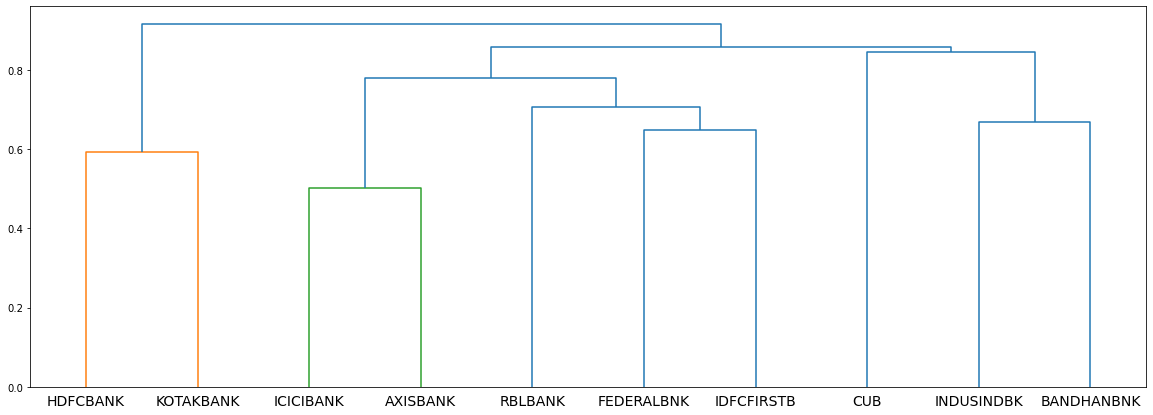

In [49]:
#Plot Dendogram
plt.figure(figsize=(20, 7))
#plt.title("Dendrograms")
dendrogram(link,labels = X.columns, leaf_font_size=14)
plt.show()

<a id='4.2'></a>
### 4.2 Steps involved in the HRP Model Design 

#### Quasi-Diagonalization and Weights Computation for HRP


Quasi-diagonalization is a matrix seriation process used in hierarchical clustering. The process involves reorganizing the covariance matrix of returns in such a way that stocks with similar returns are placed together. This matrix diagonalization allows us to distribute weights optimally following an inverse-variance allocation. For more details refer to Chapter 4 of the book.

In [50]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

#### Recursive Bisection

This step distributes the weights through recursive bisection based on the cluster covariance.

In [51]:
def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar



def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

#### Comparison of HRP with MVP

So, in this step, python functions are defined for comparing the following two portfolio design approaches.

    1. MVP - Markowitz’s Minimum-Variance Portfolio
    2. HRP - Hierarchial Risk Parity

In [52]:
def getMVP(cov):

    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    
    # Calculate efficient frontier weights using quadratic programming
    solvers.options['show_progress'] = False
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER    
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO    
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

    return list(wt)

def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    #plt.figure(figsize=(20, 10))
    #dn = sch.dendrogram(link, labels=cov.index.values)
    #plt.show()
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

#### Computation of the Weight Allocation for the Portfolios

In [53]:
def get_all_portfolios(returns):
    
    cov, corr = returns.cov(), returns.corr()
    hrp = getHRP(cov, corr)
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index=cov.index)
    portfolios = pd.DataFrame([mvp, hrp], index=['MVP', 'HRP']).T
    #portfolios = pd.DataFrame([ivp, hrp], index=['IVP', 'HRP']).T
    return portfolios

In [54]:
portfolios = get_all_portfolios(returns)
print(portfolios)

                 MVP       HRP
HDFCBANK    0.534193  0.228838
ICICIBANK   0.001554  0.105719
KOTAKBANK   0.165369  0.121604
AXISBANK    0.000581  0.086621
INDUSINDBK  0.000048  0.029938
BANDHANBNK  0.000183  0.028015
FEDERALBNK  0.000369  0.081099
IDFCFIRSTB  0.053344  0.068157
CUB         0.243509  0.172669
RBLBANK     0.000850  0.077341


Text(0.5, 1.0, 'HRP')

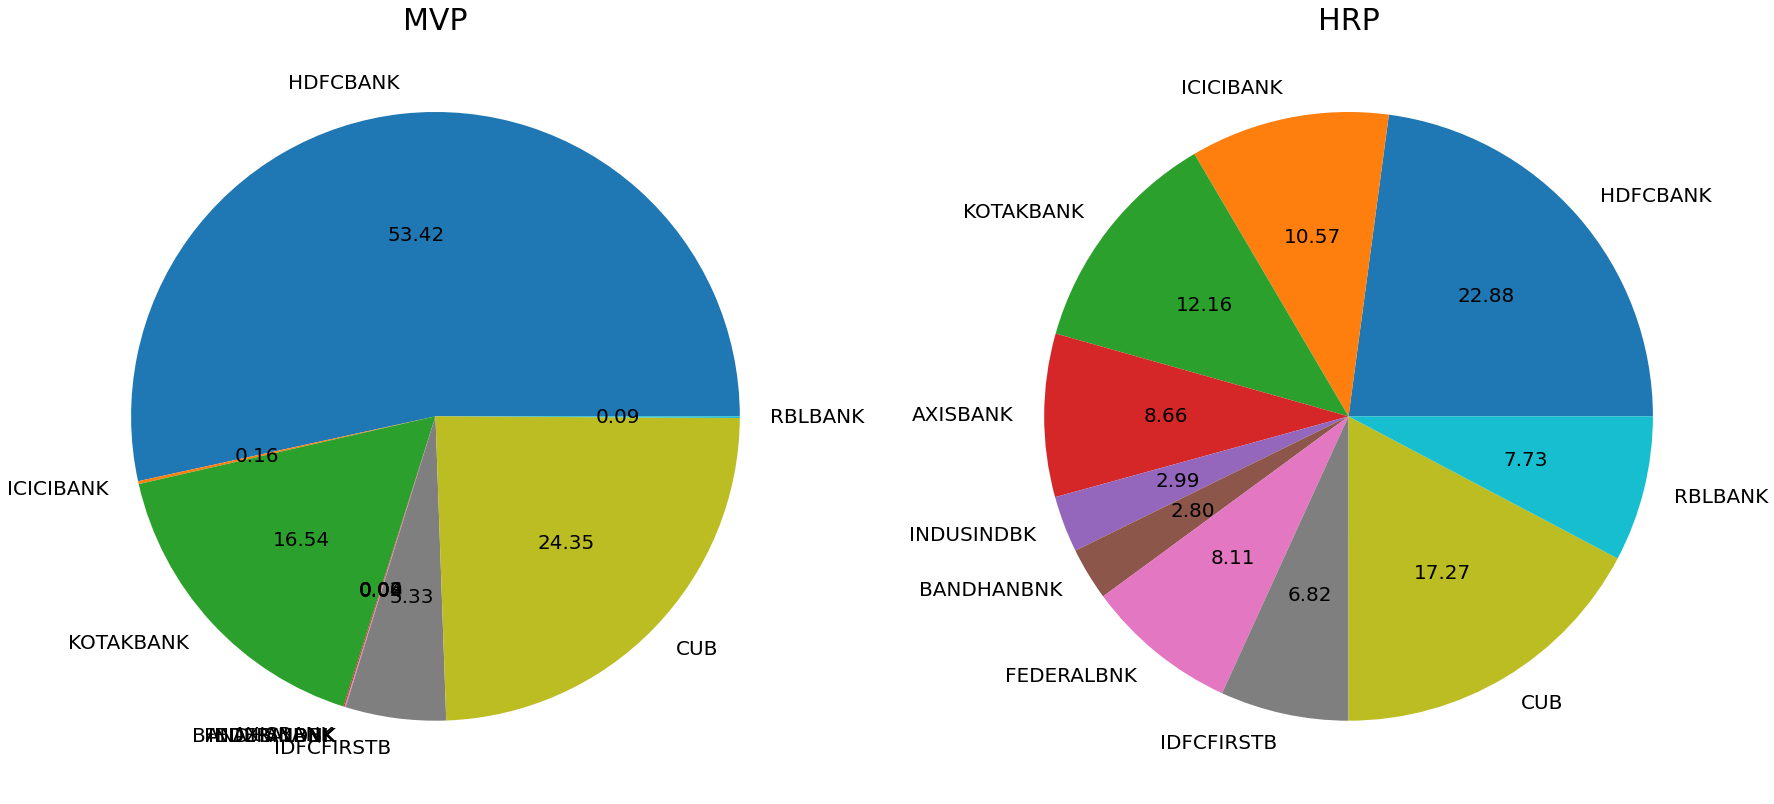

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(30,20))
ax1.pie(portfolios.iloc[:,0], labels= portfolios.index, autopct='%.2f', textprops={'fontsize': 20});
ax1.set_title('MVP',fontsize = 30)
ax2.pie(portfolios.iloc[:,1], labels=portfolios.index, autopct='%.2f', textprops={'fontsize': 20});
ax2.set_title('HRP',fontsize = 30)
#portfolios.plot.pie(subplots=True, figsize=(20, 10),legend = False);

In [56]:
# MVP - Markowitz’s Minimum-Variance Portfolio Weights
portfolios.iloc[:,0]

HDFCBANK      0.534193
ICICIBANK     0.001554
KOTAKBANK     0.165369
AXISBANK      0.000581
INDUSINDBK    0.000048
BANDHANBNK    0.000183
FEDERALBNK    0.000369
IDFCFIRSTB    0.053344
CUB           0.243509
RBLBANK       0.000850
Name: MVP, dtype: float64

In [57]:
# HRP - Hierarchial Risk Parity Portfolio Weights
portfolios.iloc[:,1]

HDFCBANK      0.228838
ICICIBANK     0.105719
KOTAKBANK     0.121604
AXISBANK      0.086621
INDUSINDBK    0.029938
BANDHANBNK    0.028015
FEDERALBNK    0.081099
IDFCFIRSTB    0.068157
CUB           0.172669
RBLBANK       0.077341
Name: HRP, dtype: float64

<a id='5'></a>
## 5. Performance Evaluation of the Portfolios 

### 5.1 Cumulative Returns - Training and Test Data 

In [58]:
Insample_Result=pd.DataFrame(np.dot(returns,np.array(portfolios)), \
                             columns=['MVP', 'HRP'], index = returns.index)
OutOfSample_Result=pd.DataFrame(np.dot(returns_test,np.array(portfolios)), \
                                columns=['MVP', 'HRP'], index = returns_test.index)

<AxesSubplot:xlabel='date', ylabel='Return'>

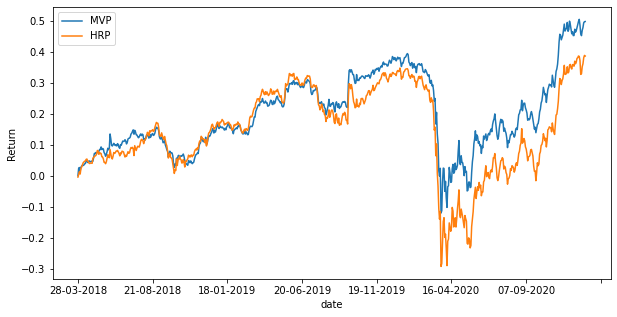

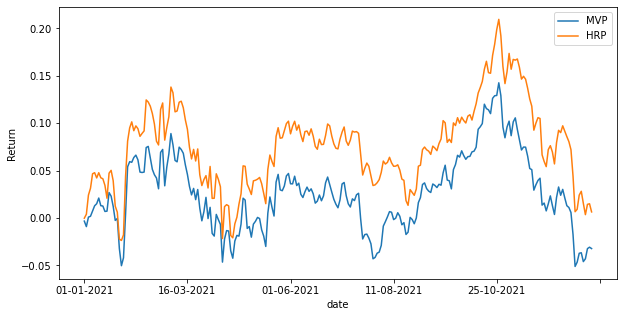

In [59]:
Insample_Result.cumsum().plot(figsize=(10, 5), ylabel = "Return")
OutOfSample_Result.cumsum().plot(figsize=(10, 5), ylabel = "Return")

In [60]:
ret_insample=Insample_Result.mean() * 252
ret_insample

MVP    0.184900
HRP    0.143595
dtype: float64

In [61]:
ret_out_of_sample = OutOfSample_Result.mean() * 252
ret_out_of_sample

MVP   -0.032964
HRP    0.006502
dtype: float64

###  5.2 Sharpe Ratio and Annual Volatility - Training and Test Data

In [62]:
#In_sample Results
stddev = Insample_Result.std() * np.sqrt(252)
sharp_ratio = (Insample_Result.mean()*np.sqrt(252))/(Insample_Result).std()
Results = pd.DataFrame(dict(stdev=stddev, sharp_ratio = sharp_ratio))
Results

stdev  sharp_ratio
MVP  0.262530     0.704301
HRP  0.294608     0.487408

In [63]:
#Outof_sample Results
stddev_oos = OutOfSample_Result.std() * np.sqrt(252)
sharp_ratio_oos = (OutOfSample_Result.mean()*np.sqrt(252))/(OutOfSample_Result).std()
Results_oos = pd.DataFrame(dict(stdev_oos=stddev_oos, sharp_ratio_oos = sharp_ratio_oos))
Results_oos

stdev_oos  sharp_ratio_oos
MVP   0.204649        -0.161075
HRP   0.224278         0.028992